# Biniary Classification in Sentiment Analysis based on IMDB dataset

## For explanations, please refer to my report. 

## Packages and preliminaries

In [1]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, SpatialDropout1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import pickle
import itertools

Using TensorFlow backend.


In [2]:
import sys
import time
from wordcloud import WordCloud
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
cur_dir = sys.path[0]
dataset_path = os.path.join(cur_dir,'movie review.csv')
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding ="ISO-8859-1")

Open file: /Users/wsx/Desktop/machine learning/individual project/movie review.csv


In [4]:
len(df)

25000

In [5]:
df.head(5)

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


Text(0.5, 1.0, 'Dataset labels distribuition')

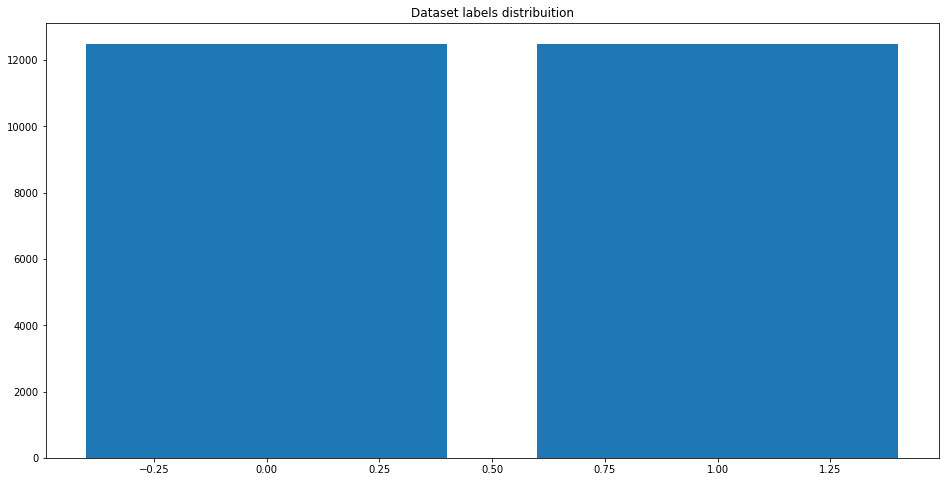

In [6]:
target_cnt = Counter(df.Sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [13]:
stop_words =stopwords.words("english")
stemmer = SnowballStemmer("english")

In [14]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [15]:
%%time
df.text = df.SentimentText.apply(lambda x: preprocess(x))

CPU times: user 6.89 s, sys: 38.2 ms, total: 6.93 s
Wall time: 6.96 s


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [16]:
df.head(10)

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1
5,"memory ""The Last Hunt"" stuck since saw 1956 13...",1
6,"Shakespeare fan, appreciate Ken Branagh done b...",0
7,privilege watching Scarface big screen beautif...,1
8,real classic. shipload sailors trying get town...,1
9,Serials short subjects originally shown theate...,1


In [17]:

import re

pat_1 = r"(?:\@|https?\://)\S+"
pat_2 = r'#\w+ ?'
combined_pat = r'|'.join((pat_1, pat_2))
www_pat = r'www.[^ ]+'
html_tag = r'<[^>]+>'
negations_ = {"isn't":"is not", "can't":"can not","couldn't":"could not", "hasn't":"has not",
                "hadn't":"had not","won't":"will not",
                "wouldn't":"would not","aren't":"are not",
                "haven't":"have not", "doesn't":"does not","didn't":"did not",
                 "don't":"do not","shouldn't":"should not","wasn't":"was not", "weren't":"were not",
                "mightn't":"might not",
                "mustn't":"must not"}
negation_pattern = re.compile(r'\b(' + '|'.join(negations_.keys()) + r')\b')


In [18]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

In [19]:
def data_cleaner(text):
    try:
        stripped = re.sub(combined_pat, '', text)
        stripped = re.sub(www_pat, '', stripped)
        cleantags = re.sub(html_tag, '', stripped)
        lower_case = cleantags.lower()
        neg_handled = negation_pattern.sub(lambda x: negations_[x.group()], lower_case)
        letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
        tokens = tokenizer.tokenize(letters_only)
        return (" ".join(tokens)).strip()
    except:
        return 'NC'

In [20]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

def post_process(data, n=1000000):
    data = data.head(n)
    data['SentimentText'] = data['SentimentText'].progress_map(data_cleaner)  
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [21]:
df = post_process(df)

progress-bar: 100%|██████████| 25000/25000 [00:03<00:00, 6975.64it/s]


## Wordcloud

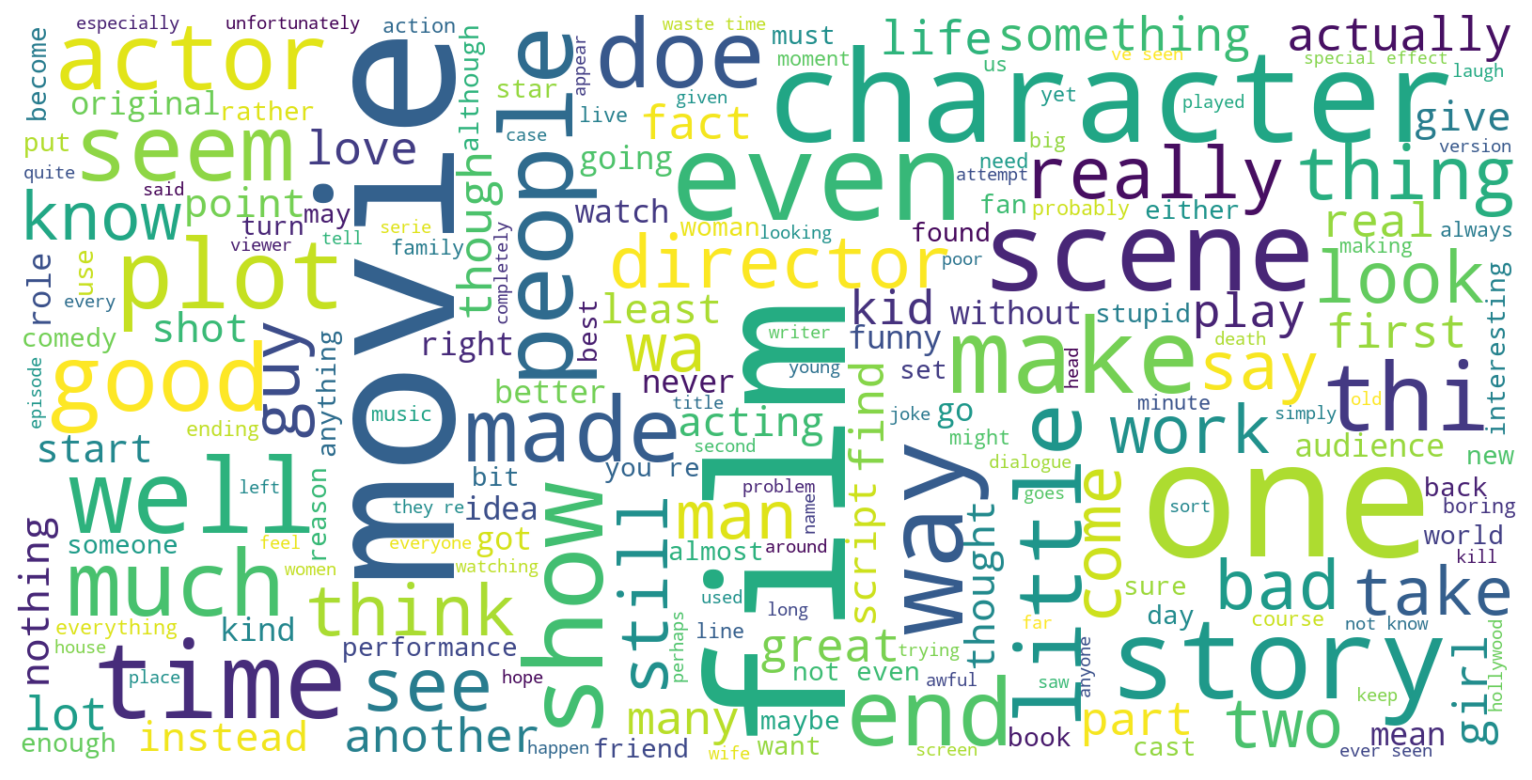

In [22]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud, STOPWORDS


neg_tweets = df[df.Sentiment == 0]
neg_string = []
for t in neg_tweets.SentimentText:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200, background_color='white').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

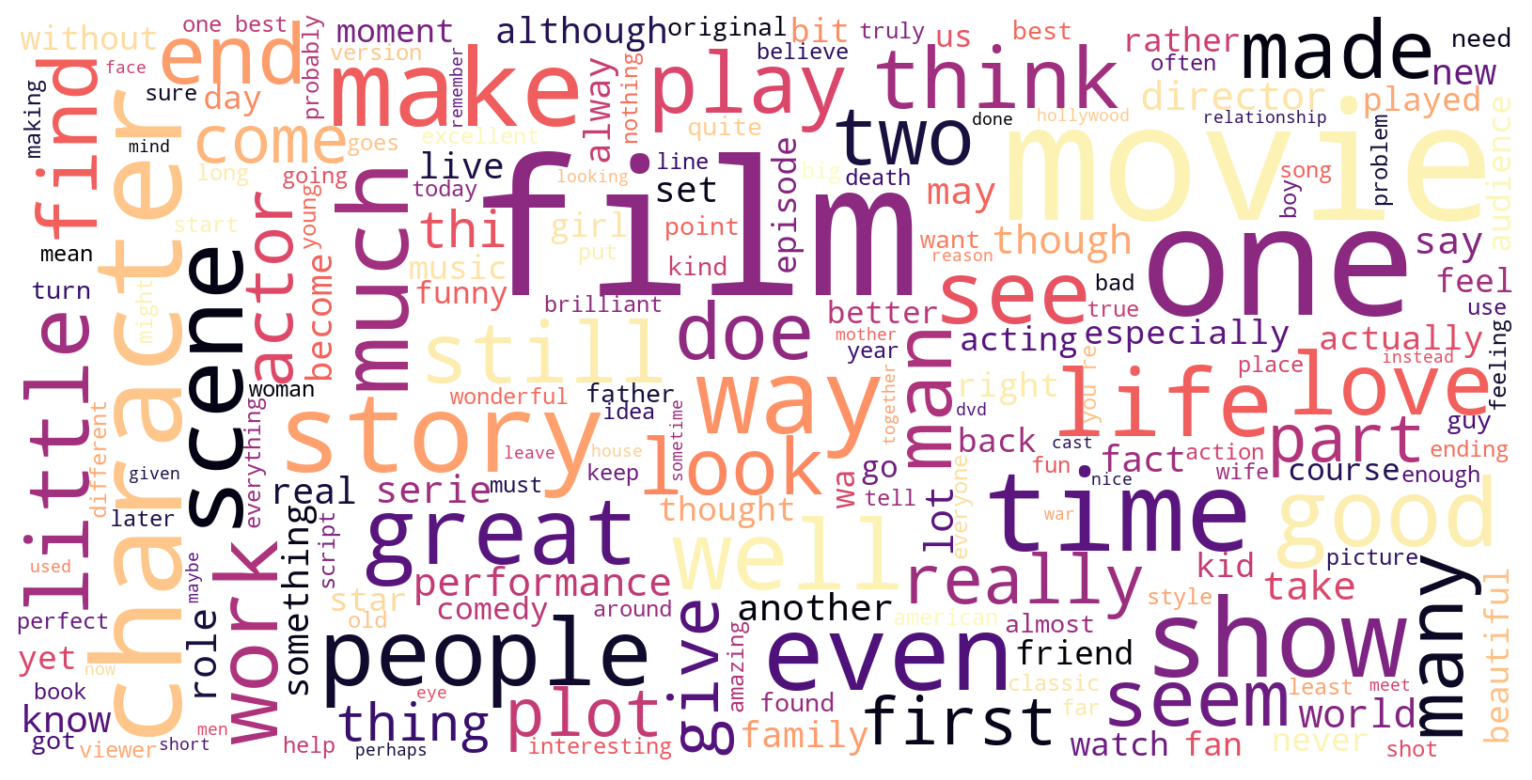

In [23]:
pos_tweets = df[df.Sentiment == 1]
pos_string = []
for t in pos_tweets.SentimentText:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma', background_color='white').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

# Machine learning models

I quit the Naive Bayes model for this dataset.

In [24]:
from sklearn.model_selection import train_test_split
SEED = 2000

x_train, x_validation, y_train, y_validation = train_test_split(df.SentimentText, 
                                                                df.Sentiment, test_size=.2, random_state=SEED)

In [25]:
len(x_train),len(x_validation)

(20000, 5000)

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
import numpy as np
from time import time

def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
  
    #Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    #Compute the precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    #Compute the average precision
    average_precision = average_precision_score(y_test, y_pred)
  
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("-"*80)
    return accuracy, precision, recall, average_precision, fpr, tpr

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

vec = TfidfVectorizer()
def classifier_comparator(vectorizer=vec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,prec, rec, avg, fp, tp))
    return result

result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Average precision-recall score: 0.85
accuracy score: 89.36%
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Average precision-recall score: 0.86
accuracy score: 90.48%
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
 

In [30]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import numpy as np

acc=[]
names = []
avg_ = []
fp_ = []
tp_ = []

for name, accuracy, prec, rec, avg, fp, tp in result:
    acc.append(accuracy*100)
    names.append(name)

    avg_.append(avg*100)
    fp_.append(fp)
    tp_.append(tp)
trace1 = go.Bar(
    x=names,
    y=acc,
    name='Accuracy percentage (%)'
)
trace3 = go.Bar(
    x=names,
    y=avg_,
    name='Average precision (%)'
)

data = [trace1, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

In [31]:
data = []
for i in range(0, len(names)):
    trace = go.Scatter(x=fp_[i], y=tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)

In [32]:
py.iplot(fig)

In [33]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

_fp_ = []
_tp_ = []
names = ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']
eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], names):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
    _fp_.append(fp)
    _tp_.append(tp)

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Average precision-recall score: 0.85
accuracy score: 89.36%
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Average precision-recall score: 0.86
accuracy score: 90.48%
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None, fit_pri

In [34]:
data = []
for i in range(0, len(_fp_)):
    trace = go.Scatter(x=_fp_[i], y=_tp_[i],
                        mode='lines', 
                        name='ROC curve {}'
                               ''.format(names[i]))
    data.append(trace)
    
layout = go.Layout(title='Receiver operating characteristic ',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=data, layout=layout)
    
py.iplot(fig)

## RNN model
Since this model took too much time to train, I didn't finish the training part. You can try to run this section if you have enough computation resources.

In [66]:
# df.head()

In [67]:
# max_fatures = 2000
# tokenizer = Tokenizer(num_words=max_fatures, split=' ')
# tokenizer.fit_on_texts(df['SentimentText'].values)
# X = tokenizer.texts_to_sequences(df['SentimentText'].values)
# X = pad_sequences(X)

In [68]:
# embed_dim = 128
# lstm_out = 196

# model = Sequential()
# model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
# model.add(SpatialDropout1D(0.4))
# model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(2,activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())

In [69]:
# Y = pd.get_dummies(df['Sentiment']).values
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
# print(X_train.shape,Y_train.shape)
# print(X_test.shape,Y_test.shape)

In [70]:
# batch_size = 32
# model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

In [71]:
# validation_size = 1500

# X_validate = X_test[-validation_size:]
# Y_validate = Y_test[-validation_size:]
# X_test = X_test[:-validation_size]
# Y_test = Y_test[:-validation_size]
# score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
# print("score: %.2f" % (score))
# print("acc: %.2f" % (acc))

In [72]:
# pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
# for x in range(len(X_validate)):
    
#     result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
#     if np.argmax(result) == np.argmax(Y_validate[x]):
#         if np.argmax(Y_validate[x]) == 0:
#             neg_correct += 1
#         else:
#             pos_correct += 1
       
#     if np.argmax(Y_validate[x]) == 0:
#         neg_cnt += 1
#     else:
#         pos_cnt += 1

# print("pos_acc", pos_correct/pos_cnt*100, "%")
# print("neg_acc", neg_correct/neg_cnt*100, "%")

In [73]:
# twt = ['Meetings: Because none of us is as dumb as all of us.']
# #vectorizing the tweet by the pre-fitted tokenizer instance
# twt = tokenizer.texts_to_sequences(twt)
# #padding the tweet to have exactly the same shape as `embedding_2` input
# twt = pad_sequences(twt, maxlen=23, dtype='int32', value=0)
# # print(twt)
# sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
# if(np.argmax(sentiment) == 0):
#     print("negative")
# elif (np.argmax(sentiment) == 1):
#     print("positive")